In [1]:
# imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the project root to Python path dynamically
# This finds the project root by looking for setup.py
current_dir = Path.cwd()
project_root = None

# Look for setup.py starting from current directory and going up
for parent in [current_dir] + list(current_dir.parents):
    if (parent / "setup.py").exists():
        project_root = parent
        break

if project_root is None:
    # Fallback: assume we're in src/example_files and go up 2 levels
    project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else current_dir.parent.parent

sys.path.insert(0, str(project_root))

# Now we can import from src
from src.core_functionality.data_processing import DataProcessingCSV
from src.core_functionality.spectrum import Spectrum, Spectra
from src.core_functionality.baseline_correction import ARPLS
from src.core_functionality.chemometrics import Chemometrics, FIT_PARAMETERS, CONFIDENCE_INTERVALS
from src.core_functionality.phase import Phase
from src.core_functionality.rate_data import RateData

print(f"All imports successful! Project root: {project_root}")

All imports successful! Project root: c:\Users\alw7s\Git\PyMESpec


In [2]:
# Details for this tutorial:
# This is a synthetic dataset made to mimic data that comes from an A<->B<->C system where where A, B, and C are different oxidation states of a catalyst.
# A -> B -> C which is the same as +5 -> +4 -> +3 oxidation states
# These are the underlying rates used to generate the data:
# Forward (reduction) +5 -> +4 -> +3
k1_fwd = 0.8   # A->B
k2_fwd = 0.13   # B->C
# Reverse (oxidation) +3 -> +4 -> +5
k2_rev = 1.0   # C->B
k1_rev = 0.20   # B->A

# The dataset has 800 collected spectra, taken every 0.25 seconds.
# A reducing agent is flowed over the catalyst for the first 100 seconds (first 400 spectra), then an oxidizing agent is flowed over the catalyst for the next 100 seconds (last 400 spectra).

# Objectives of this tutorial:
# 1. Perform baseline correction to remove the systematic baseline drift from the collected spectra.
# 2a. You should perform PSD to remove noise from the spectra.
# 2b. Find the phase offset between species.
# 3. Use chemometrics to fit the data to get the relative concentration of each species over time.
# 4. You should be able to calculate these rates listed above back from the data.


In [3]:
# Reading in data from CSV files
# Use the project_root we found in the first cell
path = project_root / "src" / "example_files" / "example_synthetic_data" 

# Names of the CSV columns to read
csv_frequency_column = "frequencies"
csv_intensity_column = "intensities"
# The initial and final rows to investigate (-1 means the last row with data)
csv_row_num_start = 1
csv_row_num_end = -1
# The spectral coordinate range to investigate (the subset of frequency values)
spectral_coordinate_start = 0
spectral_coordinate_end = -1
# Of all the data points collected this is the range of frames to investigate
starting_frame = 0
ending_frame = -1
# This is the number of data points collected per pulse in this experiment
data_per_pulse = 800

# How frequently the data was collected in seconds
collection_dt = 0.25

print(f"Looking for data in: {path}")
print(f"Path exists: {path.exists()}")

Looking for data in: c:\Users\alw7s\Git\PyMESpec\src\example_files\example_synthetic_data
Path exists: True


In [4]:
data_processor = DataProcessingCSV(
    in_dir=path,
    csv_frequency_column=csv_frequency_column,
    csv_intensity_column=csv_intensity_column,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)

spectra = data_processor.get_spectra()
print(f" Number of spectra: {len(spectra)}")

 Number of spectra: 800


In [5]:
spectra[0]


Spectrum(frequency=[1001.66944908 1003.33889816 1005.00834725 1006.67779633 1008.34724541
 1010.01669449 1011.68614357 1013.35559265 1015.02504174 1016.69449082
 1018.3639399  1020.03338898 1021.70283806 1023.37228715 1025.04173623
 1026.71118531 1028.38063439 1030.05008347 1031.71953255 1033.38898164
 1035.05843072 1036.7278798  1038.39732888 1040.06677796 1041.73622705
 1043.40567613 1045.07512521 1046.74457429 1048.41402337 1050.08347245
 1051.75292154 1053.42237062 1055.0918197  1056.76126878 1058.43071786
 1060.10016694 1061.76961603 1063.43906511 1065.10851419 1066.77796327
 1068.44741235 1070.11686144 1071.78631052 1073.4557596  1075.12520868
 1076.79465776 1078.46410684 1080.13355593 1081.80300501 1083.47245409
 1085.14190317 1086.81135225 1088.48080134 1090.15025042 1091.8196995
 1093.48914858 1095.15859766 1096.82804674 1098.49749583 1100.16694491
 1101.83639399 1103.50584307 1105.17529215 1106.84474124 1108.51419032
 1110.1836394  1111.85308848 1113.52253756 1115.19198664 11

In [6]:
# Reference samples of the pure component spectra
reference_path = project_root / "src" / "example_files" / "example_synthetic_data" / "example_baselines"
csv_ref_intensities = "normalized_intensities"
data_processor_ref = DataProcessingCSV(
    in_dir=reference_path,
    csv_frequency_column=csv_frequency_column,
    csv_intensity_column=csv_ref_intensities,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)
spectra_ref = data_processor_ref.get_spectra()
print(f" Number of reference spectra: {len(spectra_ref)}")

 Number of reference spectra: 4


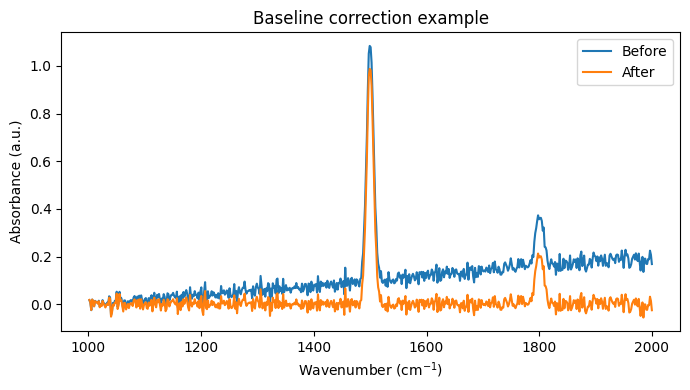

In [7]:
# Baseline correction
    
arpls = ARPLS()
package_spectra = arpls.baseline_corrected_spectra(spectra)
# plots a spectrum to show the baseline correction worked
plt.figure(figsize=(7,4))
plt.plot(spectra[0].frequencies, spectra[0].intensities, label="Before")
plt.plot(package_spectra[0].frequencies, package_spectra[0].intensities, label="After")

plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("Absorbance (a.u.)")
plt.title("Baseline correction example")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\alw7s\Git\PyMESpec\src\core_functionality\phase.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  self._phase_shift[:, i] = phases_data


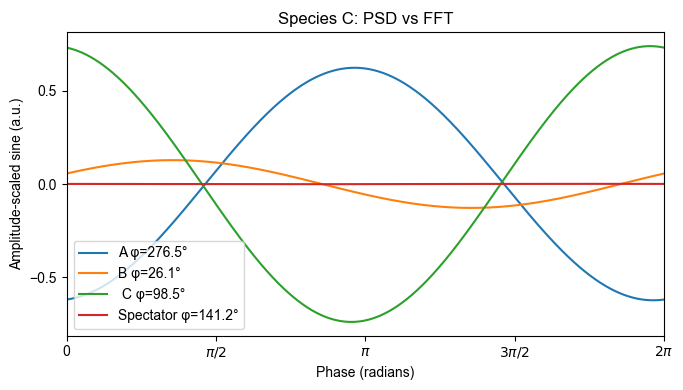

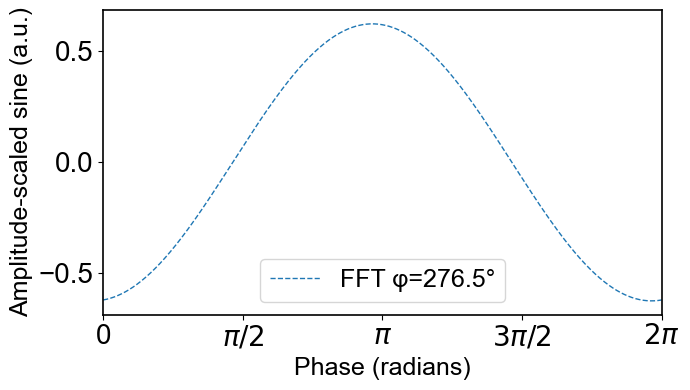

In [8]:

# ==Phase sensitive Detection Section:
harmonic_of_interest = 1  # Change this to the harmonic you want to analyze
# These are the frequencies of the species in the synthetic data
freq_A = 1500
freq_B = 1600
freq_C = 1675
freq_spectator = 1800


phase = Phase(package_spectra, num_time_points=data_per_pulse)
phase_out = phase.fourier_transform_on_avg_data(harmonic=harmonic_of_interest)


amp_fft_A, phi_fft_A = phase.fft_harmonic_amp_phase_sin_PSD(frequency=freq_A, harmonic=harmonic_of_interest)
amp_fft_B, phi_fft_B = phase.fft_harmonic_amp_phase_sin_PSD(frequency=freq_B, harmonic=harmonic_of_interest)
amp_fft_C, phi_fft_C = phase.fft_harmonic_amp_phase_sin_PSD(frequency=freq_C, harmonic=harmonic_of_interest)
amp_fft_S, phi_fft_S = phase.fft_harmonic_amp_phase_sin_PSD(frequency=freq_spectator, harmonic=harmonic_of_interest)

# Overlay
psi = np.linspace(0, 2*np.pi, data_per_pulse)
plt.figure(figsize=(7,4))
plt.plot(psi, amp_fft_A * np.sin(psi + phi_fft_A), label=f"A φ={np.degrees(phi_fft_A):.1f}°")
plt.plot(psi, amp_fft_B * np.sin(psi + phi_fft_B), label=f"B φ={np.degrees(phi_fft_B):.1f}°")
plt.plot(psi, amp_fft_C * np.sin(psi + phi_fft_C), label=f" C φ={np.degrees(phi_fft_C):.1f}°")
plt.plot(psi, amp_fft_S * np.sin(psi + phi_fft_S), label=f"Spectator φ={np.degrees(phi_fft_S):.1f}°")
plt.xlabel("Phase (radians)")
plt.ylabel("Amplitude-scaled sine (a.u.)")
plt.title("Species C: PSD vs FFT")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plt.legend()
plt.tight_layout()

# This is the built in function
plt.figure(figsize=(7,4)) 
phase_out.plot_phase_as_sine(frequency=freq_A, harmonic=harmonic_of_interest)




This is intuitive, species A and C are ~180 degrees out of phase. The marjority of their time present the other species does not coexist.
The intensity of B is lower since it has a shorter lifetime. 
The spectator does not participate so it is flat.

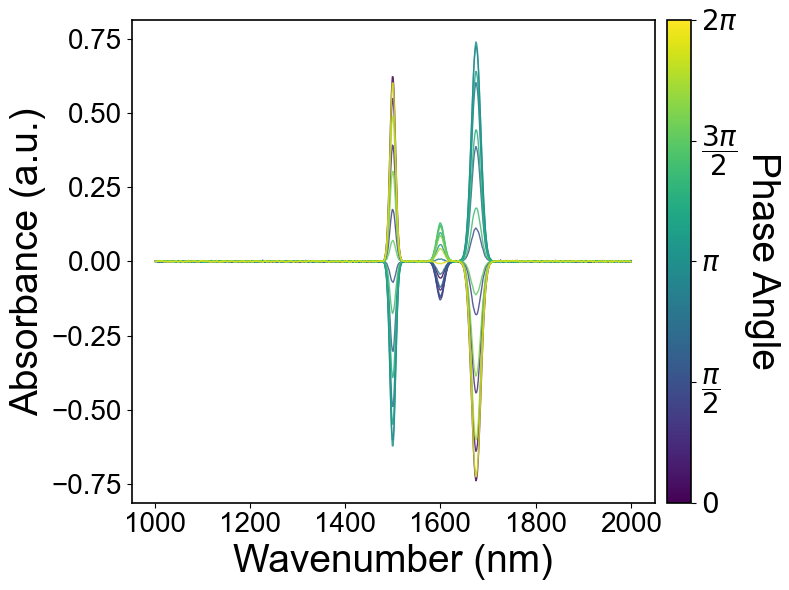

In [9]:
# The sinusoidal phase domain spectra
phase_out.plot_sinusodial_PD_spectra(sample_factor=50)

The noise in the system is removed. 
The spectator signal is not present.

Text(0, 0.5, 'Concentration (a.u.)')

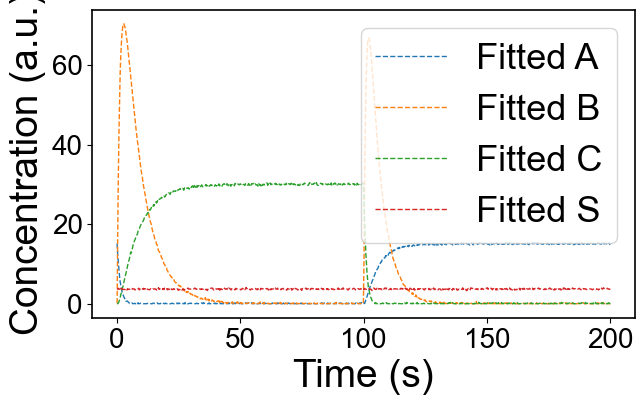

In [10]:
# Chemometrics
chemo = Chemometrics(spectra_ref)
results = chemo.compute_spectra_fitting(package_spectra, normalize_fit=False)
species_a_conc = [result[FIT_PARAMETERS][0] for result in results]
species_b_conc = [result[FIT_PARAMETERS][1] for result in results]
species_c_conc = [result[FIT_PARAMETERS][2] for result in results]
species_s_conc = [result[FIT_PARAMETERS][3] for result in results]

plt.figure(figsize=(7,4))
t = np.linspace(0, data_per_pulse*collection_dt, data_per_pulse)
plt.plot(t, species_a_conc, label="Fitted A", linestyle='--')
plt.plot(t, species_b_conc, label="Fitted B", linestyle='--')
plt.plot(t, species_c_conc, label="Fitted C", linestyle='--')
plt.plot(t, species_s_conc, label="Fitted S", linestyle='--')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Concentration (a.u.)")

From chemometrics fitting we can see when in the pulse the species are present.
We could also choose to normalize to get concentrations while excluding the spectator frequency to get concentration.

c:\Users\alw7s\Git\PyMESpec\src\core_functionality\spectrum.py:482: UserWarning: The frequency 1500 is not in the data. The nearest frequency 1499.1652754590984 was used instead.
  warnings.warn(
c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:51: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:256: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


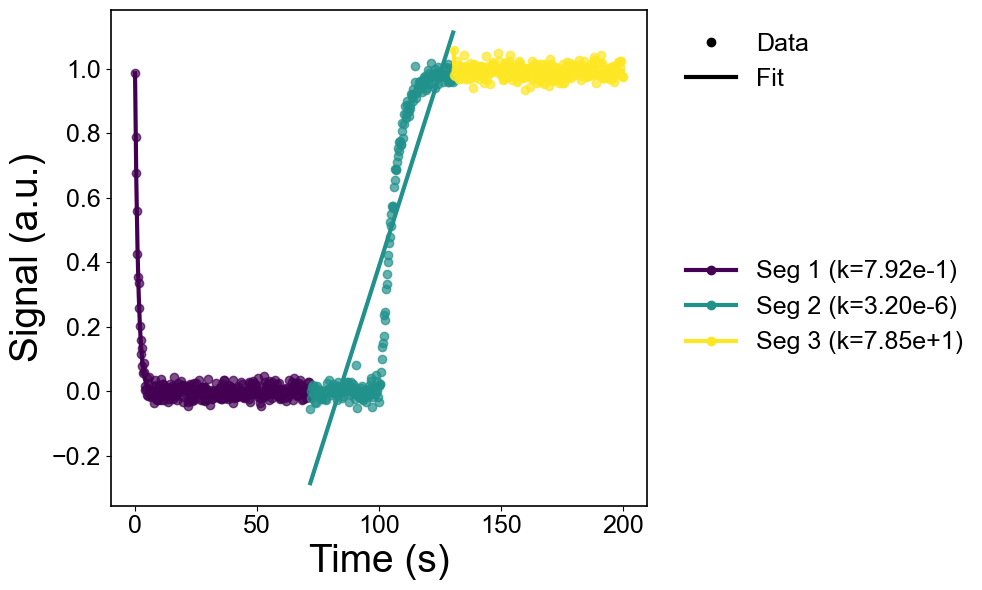

In [11]:

# Rates we may want to repeat the signal for this
rate_data = RateData(package_spectra, time_step_in_seconds=collection_dt)
output_dict_species_A = rate_data.compute_all_rate_data_single_freq(select_frequency=freq_A, num_time_points=data_per_pulse)

output = rate_data.plot_decays_and_fits(**output_dict_species_A, title="Species A")


Without adaptive fitting this is not the best fit.

c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:509: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_curr, _ = curve_fit(fitting_function, x_curr, new_curr, maxfev=5000)
c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:540: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_curr, _ = curve_fit(fitting_function, x_curr, new_curr, maxfev=5000)


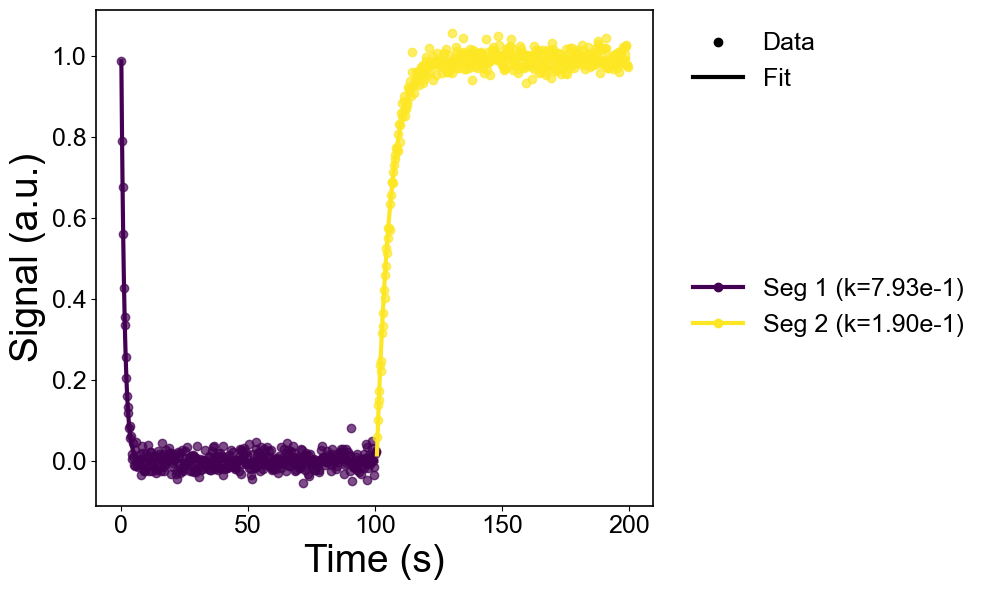

In [12]:
output_dict_species_A_adaptive = rate_data.compute_all_rate_data_single_freq(select_frequency=freq_A, num_time_points=data_per_pulse, adaptive_fitting=True, max_segments=2, adaptive_swapping_fraction=0.99)
output = rate_data.plot_decays_and_fits(**output_dict_species_A_adaptive, title="Species A Adaptive")

This is a good fit.
The original rates shown above are
*Forward (reduction) +5 -> +4 -> +3
k1_fwd = 0.8   # A->B
k2_fwd = 0.13   # B->C
*Reverse (oxidation back) +3 -> +4 -> +5
k2_rev = 1.0   # C->B
k1_rev = 0.20   # B->A

In [13]:
print("done")

done
